In [1]:
%pip install numpy torch matplotlib datasets tqdm TorchCRF

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\amart\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
###############################################
# Part 1: Imports and Setup
###############################################
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset

# Try to import CRF; if not installed, please install via: pip install torchcrf
try:
    from TorchCRF import CRF
except ImportError:
    raise ImportError("Please install torchcrf using 'pip install torchcrf'.")

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

import torch

# Force usage of GPU 0 (if you have more than one GPU, adjust the index).
# Check if CUDA is available. If not, fall back to CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Quick debug check
print("CUDA available?", torch.cuda.is_available())
if device.type == "cuda":
    print("CUDA device name:", torch.cuda.get_device_name(0))


model_name = "SpanBERT/spanbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

###############################################
# Part 2: Evaluation Metric Function
###############################################
def exact_match_score(predictions, references):
    """
    Computes the Exact Match (EM) percentage between predictions and ground truth.
    """
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100  # Convert to percentage

# Quick test:
print("EM test:", exact_match_score(["answer", "test"], ["answer", "wrong"]))


C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0
CUDA available? True
CUDA device name: NVIDIA GeForce RTX 4060 Laptop GPU
EM test: 50.0


In [3]:
###############################################
# Part 3: Preprocessing Functions (Fixed)
###############################################
# Global hyperparameters for tokenization
max_length = 384
doc_stride = 128

def preprocess_baseline(examples):
    """
    Tokenize examples for the baseline QA model.
    For each example, computes:
      - input_ids, attention_mask, token_type_ids
      - start_positions and end_positions (using first answer if available)
      - offset_mapping, context, and answers (replicated for each overflow feature)
    """
    outputs = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    start_positions = []
    end_positions = []
    new_offset_mapping = []
    new_context = []
    new_answers = []
    
    for i, offset in enumerate(outputs["offset_mapping"]):
        sample_index = outputs["overflow_to_sample_mapping"][i]
        context = examples["context"][sample_index]
        new_context.append(context)
        new_answers.append(examples["answers"][sample_index])
        
        answers = examples["answers"][sample_index]
        if len(answers["answer_start"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
        else:
            answer_start = answers["answer_start"][0]
            answer_text = answers["text"][0]
            answer_end = answer_start + len(answer_text)
            token_start_index, token_end_index = None, None
            for idx, (s, e) in enumerate(offset):
                if s <= answer_start < e:
                    token_start_index = idx
                if s < answer_end <= e:
                    token_end_index = idx
                    break
            if token_start_index is None or token_end_index is None:
                start_positions.append(0)
                end_positions.append(0)
            else:
                start_positions.append(token_start_index)
                end_positions.append(token_end_index)
        new_offset_mapping.append(offset)
    
    outputs["start_positions"] = start_positions
    outputs["end_positions"] = end_positions
    outputs["context"] = new_context
    outputs["offset_mapping"] = new_offset_mapping
    outputs["answers"] = new_answers
    return outputs

def preprocess_crf(examples):
    """
    Tokenize examples for the CRF model.
    For each example, creates:
      - input_ids, attention_mask, token_type_ids, offset_mapping, and context
      - crf_labels: binary labels for each token (1 if token is inside the answer span, 0 otherwise)
      - answers: replicated from the original sample for later evaluation.
    """
    outputs = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    crf_labels = []
    new_offset_mapping = []
    new_context = []
    new_answers = []
    
    for i, offset in enumerate(outputs["offset_mapping"]):
        sample_index = outputs["overflow_to_sample_mapping"][i]
        context = examples["context"][sample_index]
        new_context.append(context)
        new_answers.append(examples["answers"][sample_index])
        
        answers = examples["answers"][sample_index]
        labels = [0] * len(offset)
        if len(answers["answer_start"]) > 0:
            answer_start = answers["answer_start"][0]
            answer_text = answers["text"][0]
            answer_end = answer_start + len(answer_text)
            for idx, (s, e) in enumerate(offset):
                if s == 0 and e == 0:
                    continue
                if s >= answer_start and e <= answer_end:
                    labels[idx] = 1
        crf_labels.append(labels)
        new_offset_mapping.append(offset)
    
    outputs["crf_labels"] = crf_labels
    outputs["context"] = new_context
    outputs["offset_mapping"] = new_offset_mapping
    outputs["answers"] = new_answers
    return outputs

In [4]:
###############################################
# Part 4: Model Definitions
###############################################
class SpanBERTForQA(nn.Module):
    """
    Standard SpanBERT-based Question Answering model:
      - Uses a pretrained SpanBERT encoder.
      - Predicts start and end logits using a linear layer.
    """
    def __init__(self, model_name):
        super(SpanBERTForQA, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.qa_outputs = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask, token_type_ids, start_positions=None, end_positions=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state  # shape: (batch, seq_len, hidden_size)
        logits = self.qa_outputs(sequence_output)      # shape: (batch, seq_len, 2)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)         # shape: (batch, seq_len)
        end_logits = end_logits.squeeze(-1)
        loss = None
        if start_positions is not None and end_positions is not None:
            loss_fct = nn.CrossEntropyLoss()
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            loss = (start_loss + end_loss) / 2
        return loss, start_logits, end_logits

# class SpanBERTCRFForQA(nn.Module):
#     """
#     SpanBERT-CRF model:
#       - Uses a pretrained SpanBERT encoder.
#       - Applies a linear layer for token-level classification (2 classes).
#       - Uses a CRF layer to decode the best label sequence.
#     """
#     def __init__(self, model_name):
#         super(SpanBERTCRFForQA, self).__init__()
#         self.bert = AutoModel.from_pretrained(model_name)
#         self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
#         self.crf = CRF(2,True)

#     def forward(self, input_ids, attention_mask, token_type_ids, crf_labels=None):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
#         sequence_output = outputs.last_hidden_state
#         emissions = self.classifier(sequence_output)
#         if crf_labels is not None:
#             loss = -self.crf(emissions, crf_labels, mask=attention_mask.bool(), reduction='mean')
#             return loss, None
#         else:
#             prediction = self.crf.decode(emissions, mask=attention_mask.bool())
#             return None, prediction


In [5]:
###############################################
# Part 5: Answer Reconstruction Functions
###############################################
def reconstruct_answer(example):
    """
    Reconstructs the predicted answer string for the baseline model using offset mapping.
    Expects:
      - "offset_mapping": list of (start, end) for each token.
      - "context": the original context string.
      - "pred_start" and "pred_end": predicted token indices.
    """
    offset = example["offset_mapping"]
    context = example["context"]
    if example["pred_start"] > example["pred_end"]:
        return ""
    start_char = offset[example["pred_start"]][0]
    end_char = offset[example["pred_end"]][1]
    return context[start_char:end_char]

def reconstruct_answer_crf(example, prediction_labels):
    """
    Reconstructs the answer text for the CRF model using predicted labels and offset mapping.
    Takes the contiguous span between the first and last token labeled as 1.
    """
    offset = example["offset_mapping"]
    context = example["context"]
    indices = [i for i, label in enumerate(prediction_labels) if label == 1]
    if not indices:
        return ""
    start_idx = indices[0]
    end_idx = indices[-1]
    start_char = offset[start_idx][0]
    end_char = offset[end_idx][1]
    return context[start_char:end_char]


In [6]:
###############################################
# Part 6: Training and Evaluation Functions
###############################################
# We add gradient clipping to improve stability (clip_norm = 1.0)
def train_baseline(model, dataloader, optimizer, device, clip_norm=1.0):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training Baseline"):
        # Move inputs to GPU
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        token_type_ids = batch["token_type_ids"].to(device, non_blocking=True)
        start_positions = batch["start_positions"].to(device, non_blocking=True)
        end_positions = batch["end_positions"].to(device, non_blocking=True)
        
        optimizer.zero_grad()
        loss, _, _ = model(
            input_ids, attention_mask, token_type_ids,
            start_positions, end_positions
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate_baseline(model, dataloader, device):
    model.eval()
    predictions = []
    references = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Baseline"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            contexts = batch["context"]
            offset_mappings = batch["offset_mapping"]
            _, start_logits, end_logits = model(input_ids, attention_mask, token_type_ids)
            start_preds = torch.argmax(start_logits, dim=1).cpu().numpy()
            end_preds = torch.argmax(end_logits, dim=1).cpu().numpy()
            for i in range(len(start_preds)):
                example = {
                    "offset_mapping": offset_mappings[i],
                    "context": contexts[i],
                    "pred_start": int(start_preds[i]),
                    "pred_end": int(end_preds[i]),
                }
                pred_answer = reconstruct_answer(example)
                predictions.append(pred_answer)
                ans = batch["answers"][i]["text"][0] if len(batch["answers"][i]["text"]) > 0 else ""
                references.append(ans)
    return exact_match_score(predictions, references)

def train_crf(model, dataloader, optimizer, device, clip_norm=1.0):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training CRF"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        crf_labels = batch["crf_labels"].to(device)
        loss, _ = model(input_ids, attention_mask, token_type_ids, crf_labels)
        loss=loss.mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_crf(model, dataloader, device):
    model.eval()
    predictions = []
    references = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating CRF"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            contexts = batch["context"]
            offset_mappings = batch["offset_mapping"]
            _, pred_labels = model(input_ids, attention_mask, token_type_ids)
            for i in range(len(pred_labels)):
                example = {
                    "offset_mapping": offset_mappings[i],
                    "context": contexts[i],
                }
                pred_answer = reconstruct_answer_crf(example, pred_labels[i])
                predictions.append(pred_answer)
                ans = batch["answers"][i]["text"][0] if len(batch["answers"][i]["text"]) > 0 else ""
                references.append(ans)
    return exact_match_score(predictions, references)

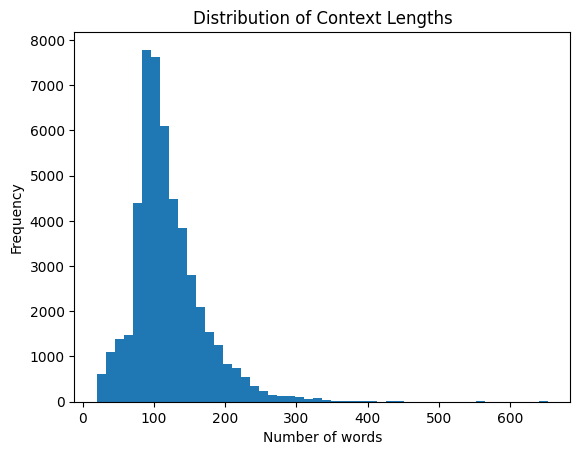

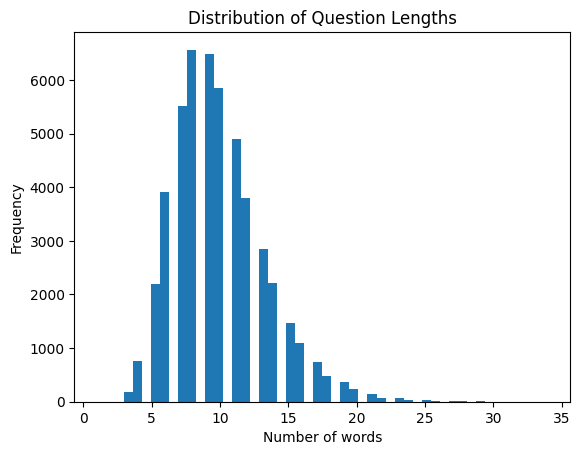

<Figure size 640x480 with 0 Axes>

In [7]:
###############################################
# Part 7: Data Loading and Exploratory Data Analysis (EDA)
###############################################
# Load SQuAD v2 dataset and select subsets:
# Training: 50k samples; Validation: 15k samples
dataset = load_dataset("squad_v2")
train_dataset = dataset["train"].shuffle(seed=seed).select(range(50000))
dev_dataset = dataset["validation"].shuffle(seed=seed).select(range(10000))

# EDA: Plot distribution of context lengths
context_lengths = [len(x.split()) for x in train_dataset["context"]]
plt.hist(context_lengths, bins=50)
plt.title("Distribution of Context Lengths")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.savefig("context_length_distribution.png")
plt.show()
plt.clf()

# EDA: Plot distribution of question lengths
question_lengths = [len(x.split()) for x in train_dataset["question"]]
plt.hist(question_lengths, bins=50)
plt.title("Distribution of Question Lengths")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.savefig("question_length_distribution.png")
plt.show()
plt.clf()

In [8]:
###############################################
# Part 8: Tokenizer Initialization and Data Preprocessing (Fixed)
###############################################
# (Re)initialize the tokenizer (if needed)
model_name = "SpanBERT/spanbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

print("Preprocessing data for the baseline model...")
# Remove only the unnecessary columns; keep "answers" and "context"
remove_cols = ["question", "title", "id"]

# Map the preprocessing functions for the baseline model
train_baseline_features = train_dataset.map(preprocess_baseline, batched=True, remove_columns=remove_cols)
dev_baseline_features = dev_dataset.map(preprocess_baseline, batched=True, remove_columns=remove_cols)

# Set the format: convert selected columns to torch tensors, but keep all columns (like "answers") in original format.
train_baseline_features.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "token_type_ids", "start_positions", "end_positions", "offset_mapping", "context"],
    output_all_columns=True
)
dev_baseline_features.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "token_type_ids", "start_positions", "end_positions", "offset_mapping", "context"],
    output_all_columns=True
)

print("Preprocessing data for the CRF model...")
# Map the preprocessing functions for the CRF model
train_crf_features = train_dataset.map(preprocess_crf, batched=True, remove_columns=remove_cols)
dev_crf_features = dev_dataset.map(preprocess_crf, batched=True, remove_columns=remove_cols)

train_crf_features.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "token_type_ids", "crf_labels", "offset_mapping", "context"],
    output_all_columns=True
)
dev_crf_features.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "token_type_ids", "crf_labels", "offset_mapping", "context"],
    output_all_columns=True
)


Preprocessing data for the baseline model...
Preprocessing data for the CRF model...


In [ ]:
###############################################
# Part 9: Create DataLoaders with a Custom Collate Function
###############################################
def custom_collate(batch):
    """
    Custom collate function that stacks tensor fields but leaves other fields as a list.
    """
    collated = {}
    # Define the keys that should be stacked into tensors.
    numeric_keys = ["input_ids", "attention_mask", "token_type_ids", 
                    "start_positions", "end_positions", "crf_labels"]
    for key in batch[0]:
        if key in numeric_keys and key in batch[0]:
            collated[key] = torch.stack([b[key] for b in batch])
        else:
            # For keys like "offset_mapping", "context", and "answers", keep them as lists.
            collated[key] = [b[key] for b in batch]
    return collated

# Set batch sizes
train_bs = 8  # training batch size
dev_bs = 8    # validation batch size

# Create DataLoaders using the custom collate function
train_baseline_loader = DataLoader(train_baseline_features, batch_size=train_bs, shuffle=True, collate_fn=custom_collate)
dev_baseline_loader = DataLoader(dev_baseline_features, batch_size=dev_bs, collate_fn=custom_collate)

train_crf_loader = DataLoader(train_crf_features, batch_size=train_bs, shuffle=True, collate_fn=custom_collate)
dev_crf_loader = DataLoader(dev_crf_features, batch_size=dev_bs, collate_fn=custom_collate)


# Import the base CRF from torchcrf
from TorchCRF import CRF as BaseCRF

class PatchedCRF(BaseCRF):
    def __init__(self, num_labels, pad_idx):
        super().__init__(num_labels, pad_idx)

    def _initialize_parameters(self, pad_idx):
        with torch.no_grad():
            nn.init.uniform_(self.start_trans, -0.1, 0.1)
            nn.init.uniform_(self.trans_matrix, -0.1, 0.1)
        # Note: We are not zeroing out transitions for a pad label here,
        # since for our binary labeling we do not designate a pad token.

    def decode(self, emissions, mask):
        """Decode the best sequence using Viterbi."""
        return super().viterbi_decode(emissions, mask)



# Define the SpanBERT-CRF model using our patched CRF.
class SpanBERTCRFForQA(nn.Module):
    """
    SpanBERT-CRF model:
      - Uses a pretrained SpanBERT encoder.
      - Applies a linear layer for token-level classification (2 classes).
      - Uses a CRF layer (patched) to decode the best label sequence.
    """
    def __init__(self, model_name):
        super(SpanBERTCRFForQA, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
        # Use the patched CRF; we pass pad_idx as 0 (this value will not be used specially).
        self.crf = PatchedCRF(2, 0)
        
    def forward(self, input_ids, attention_mask, token_type_ids, crf_labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        sequence_output = outputs.last_hidden_state  # shape: (batch, seq_len, hidden_size)
        emissions = self.classifier(sequence_output)   # shape: (batch, seq_len, num_tags)
        if crf_labels is not None:
            # Compute the negative log-likelihood loss.
            loss = -self.crf(emissions, crf_labels, mask=attention_mask.bool())
            return loss, None
        else:
            # Decode the best sequence.
            prediction = self.crf.decode(emissions, mask=attention_mask.bool())
            return None, prediction

baseline_model = SpanBERTForQA(model_name).to(device)
crf_model = SpanBERTCRFForQA(model_name).to(device)

print("Models initialized successfully.")

epochs = 6

# Baseline model optimizer and scheduler
total_steps_baseline = len(train_baseline_loader) * epochs
optimizer_baseline = AdamW(baseline_model.parameters(), lr=3e-5)
scheduler_baseline = get_linear_schedule_with_warmup(optimizer_baseline, num_warmup_steps=0, num_training_steps=total_steps_baseline)

# CRF model optimizer and scheduler
total_steps_crf = len(train_crf_loader) * epochs
optimizer_crf = AdamW(crf_model.parameters(), lr=3e-5)
scheduler_crf = get_linear_schedule_with_warmup(optimizer_crf, num_warmup_steps=0, num_training_steps=total_steps_crf)

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models initialized successfully.


C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

# baseline_train_losses = []
# baseline_val_em = []

# print("Training Baseline SpanBERT Model...")

# for epoch in range(epochs):
#     print(f"Epoch {epoch+1}/{epochs}")
#     # Train on the GPU
#     train_loss = train_baseline(
#         baseline_model, 
#         train_baseline_loader, 
#         optimizer_baseline, 
#         device=device, 
#         clip_norm=1.0
#     )
#     baseline_train_losses.append(train_loss)
    
#     # Evaluate on the GPU
#     val_em = evaluate_baseline(
#         baseline_model, 
#         dev_baseline_loader, 
#         device=device
#     )
#     baseline_val_em.append(val_em)
    
#     print(f"Baseline Epoch {epoch+1} - Training Loss: {train_loss:.4f}, Validation EM: {val_em:.2f}%")
#     scheduler_baseline.step()


In [ ]:

# import torch

# # Specify the checkpoint file name (you can adjust the epoch number as needed)
# # checkpoint_path = "Baseline_model_epoch_6.pth"
# # torch.save(crf_model.state_dict(), checkpoint_path)
# # print(f"Saved CRF model checkpoint to {checkpoint_path}")

# # Print a detailed GPU memory summary.
# # This will show which tensors (if any) are still allocated.
# print("GPU Memory Summary:")
# print(torch.cuda.memory_summary(device=device, abbreviated=False))

# # Optionally, free GPU memory by deleting the model and clearing cache.
# del baseline_model
# torch.cuda.empty_cache()
# print("Cleared CRF model from GPU memory.")


In [ ]:

crf_train_losses = []
crf_val_em = []

save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

print("Training SpanBERT-CRF Model...")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss = train_crf(crf_model, train_crf_loader, optimizer_crf, device, clip_norm=1.0)
    crf_train_losses.append(train_loss)
    
    val_em = evaluate_crf(crf_model, dev_crf_loader, device)
    crf_val_em.append(val_em)
    
    print(f"CRF Epoch {epoch+1} - Training Loss: {train_loss:.4f}, Validation EM: {val_em:.2f}%")
    scheduler_crf.step()
    model_path = os.path.join(save_dir, f"Baseline_epoch_{epoch+1}.pth")
    torch.save(baseline_model.state_dict(), model_path)
    print(f"✅ Model saved: {model_path}")


Training SpanBERT-CRF Model...
Epoch 1/6


Evaluating CRF: 100%|██████████| 1296/1296 [03:57<00:00,  5.47it/s]


CRF Epoch 1 - Training Loss: 1.4019, Validation EM: 63.60%
✅ Model saved: ./saved_models\Baseline_epoch_1.pth
Epoch 2/6


Evaluating CRF: 100%|██████████| 1296/1296 [03:55<00:00,  5.51it/s]


CRF Epoch 2 - Training Loss: 1.2162, Validation EM: 61.56%
✅ Model saved: ./saved_models\Baseline_epoch_2.pth
Epoch 3/6


Evaluating CRF: 100%|██████████| 1296/1296 [03:54<00:00,  5.53it/s]


CRF Epoch 3 - Training Loss: 1.0823, Validation EM: 60.96%
✅ Model saved: ./saved_models\Baseline_epoch_3.pth
Epoch 4/6


Evaluating CRF: 100%|██████████| 1296/1296 [03:54<00:00,  5.54it/s]


CRF Epoch 4 - Training Loss: 0.9946, Validation EM: 62.84%
✅ Model saved: ./saved_models\Baseline_epoch_4.pth
Epoch 5/6


Evaluating CRF: 100%|██████████| 1296/1296 [03:43<00:00,  5.80it/s]


CRF Epoch 5 - Training Loss: 0.9291, Validation EM: 61.21%
✅ Model saved: ./saved_models\Baseline_epoch_5.pth
Epoch 6/6


Evaluating CRF: 100%|██████████| 1296/1296 [04:00<00:00,  5.39it/s]


CRF Epoch 6 - Training Loss: 0.8277, Validation EM: 59.93%
✅ Model saved: ./saved_models\Baseline_epoch_6.pth


In [13]:
from TorchCRF import CRF
print(dir(CRF))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_calc_trans_score_for_num_llh', '_call_impl', '_compiled_call_impl', '_compute_denominator_log_likelihood', '_compute_numerator_log_likelihood', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_initialize_parameters', '_load_from_state_dict', '_maybe_warn_non_full_backward_hook', '_named_members', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_version', '_viterbi_compute_best_path', '_wrapped_call_impl', 'add_module', 'apply', 'bfloat1

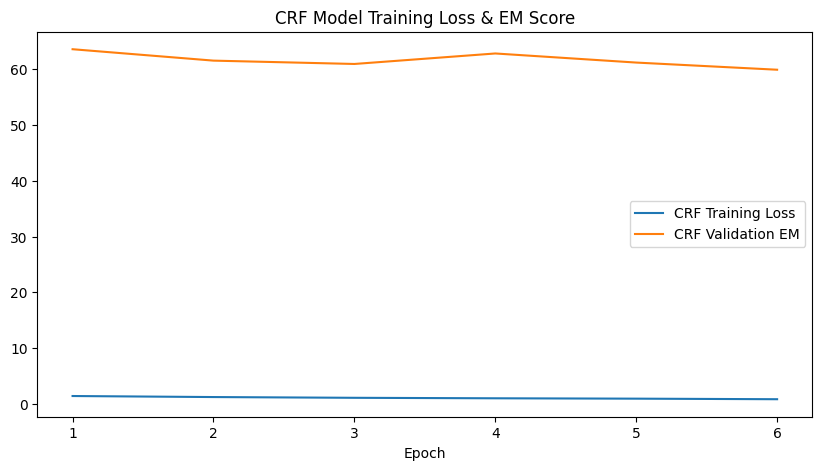

Evaluating CRF: 100%|██████████| 1296/1296 [03:43<00:00,  5.80it/s]

Final CRF Model EM: 59.93%


<Figure size 640x480 with 0 Axes>

In [ ]:

epochs_range = range(1, epochs + 1)

# # Plot Baseline Model curves
# plt.figure(figsize=(10, 5))
# plt.plot(epochs_range, baseline_train_losses, label="Baseline Training Loss")
# plt.plot(epochs_range, baseline_val_em, label="Baseline Validation EM")
# plt.title("Baseline Model Training Loss & EM Score")
# plt.xlabel("Epoch")
# plt.legend()
# plt.savefig("baseline_training_plot.png")
# plt.show()
# plt.clf()

# Plot CRF Model curves
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, crf_train_losses, label="CRF Training Loss")
plt.plot(epochs_range, crf_val_em, label="CRF Validation EM")
plt.title("CRF Model Training Loss & EM Score")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("crf_training_plot.png")
plt.show()
plt.clf()

# Final evaluation on the validation set
# final_baseline_em = evaluate_baseline(baseline_model, dev_baseline_loader, device)
final_crf_em = evaluate_crf(crf_model, dev_crf_loader, device)
# print(f"Final Baseline Model EM: {final_baseline_em:.2f}%")
print(f"Final CRF Model EM: {final_crf_em:.2f}%")


In [15]:
import torch

# Specify the checkpoint file name (you can adjust the epoch number as needed)
checkpoint_path = "crf_model_epoch_6.pth"
torch.save(crf_model.state_dict(), checkpoint_path)
print(f"Saved CRF model checkpoint to {checkpoint_path}")


Saved CRF model checkpoint to crf_model_epoch_6.pth
